# Before reading

This kernel is a Korean translation of [the kernel written by SRK](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize).  
이 커널은 [SRK님이 작성한 커널](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize)을 한국어로 번역한 것입니다.


커널의 내용 중 라이브러리 메서드가 변경 및 제거 된 경우(deprecated), 해당 목적에 맞는 다른 메서드로 수정되었으니 참고 바랍니다.

# Start
이 노트북에서는, Zillow prize competition에서 주어지는 데이터들을 살펴보도록 하겠습니다. 우리가 데이터에 대해 깊게 보기전에, 대회에 대해 조금 알아야 하는 것들을 보겠습니다.



**Zillow:**

Zillow는 2006년에 설립된 온라인 부동산 데이터베이스 회사입니다. - Wikipedia

**Zestimate:**

"Zestimates"는 750만개의 통계적인 수치와 각 재산에 대한 수백개의 데이터 포인트를 분석하는 머신러닝 모델을 기반으로 추정되는 주택가치입니다. 그리고 계속적으로 중간마진에 대한 오류를 개선해나가고 있습니다(14%에서 오늘날 5%로).

**Objective:**

Zestimate의 잔차(residual error)를 향상시키는 모델 만들기

대회는 2개로 이루어져 있습니다. 일반 대회는 2018년 1월에 시작하며, 50,000 달러의 상금이 존재합니다. 조금은 달라질 수 있기 때문에, [대회 개요](https://www.kaggle.com/c/zillow-prize-1/overview/description)와 [상금 상세설명](https://www.kaggle.com/c/zillow-prize-1/overview/prizes)을 읽어보길 바랍니다.



그럼 첫 번째로, 필수적인 모듈을 불러오겠습니다.

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

그럼 'input' 폴더에 존재하는 파일들을 나열해보도록 하겠습니다.

In [0]:
from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

kaggle.json
properties_2016.csv
properties_2016.csv.zip
properties_2017.csv
properties_2017.csv.zip
sample_data
sample_submission.csv.zip
train_2016_v2.csv
train_2016_v2.csv.zip
train_2017.csv
train_2017.csv.zip
zillow_data_dictionary.xlsx



첫 번째로 train 데이터 파일을 탐색하며 시작해보도록 하겠습니다.

In [0]:
train_df = pd.read_csv("./input/train_2016_v2.csv", parse_dates = ["transactiondate"])
train_df.shape

(90275, 3)

In [0]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


**Logerror:**

이 대회의 타겟 변수는 "logerror"입니다. 고로, 먼저 이 변수에 대해 분석해보도록 하겠습니다.

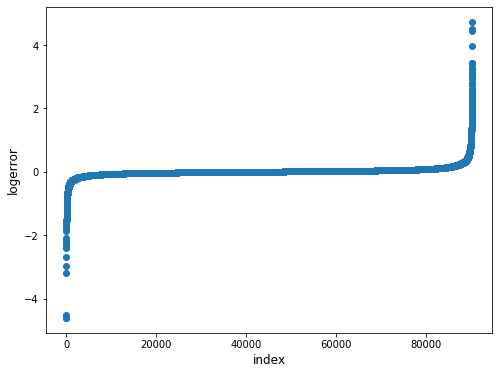

In [0]:
plt.figure(figsize=(8, 6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

양 끝에 조금의 outlier들이 있는 것을 볼 수 있고, 대체로 보기 좋아보입니다.  
outlier들을 제거하고, 똑같은 과정으로 histogram plot을 그려보도록 하죠.

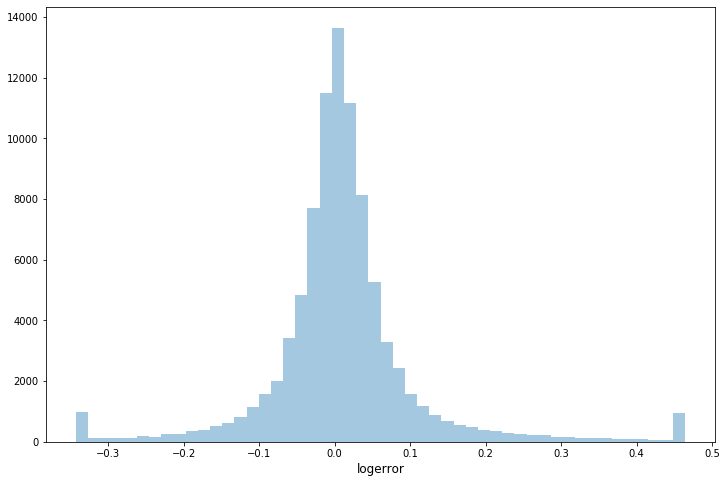

In [0]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df.loc[train_df['logerror']>ulimit, 'logerror'] = ulimit
train_df.loc[train_df['logerror']<llimit, 'logerror'] = llimit

plt.figure(figsize=(12, 8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

와우! 좋은 log error 정규 분포가 되었습니다.  



**Transaction Date:**  
이제 date 필드에 대해 살펴봅시다. 먼저 각 달의 트랜잭션의 수를 확인해보도록 하겠습니다.

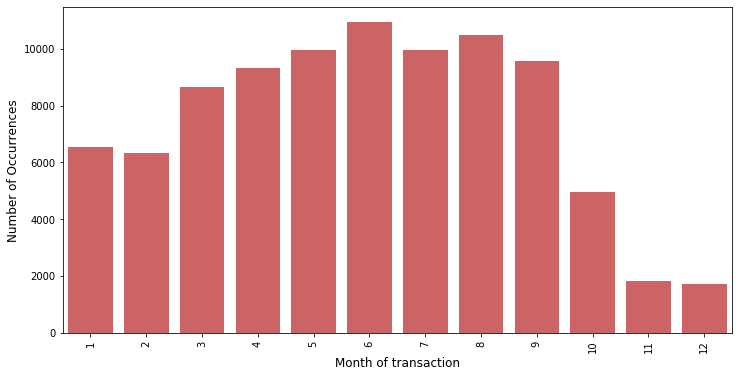

In [0]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

데이터 설명 페이지의 "Train 데이터는 2016년 10월 15일 이전의 모든 트랜잭션 데이터와 2016년 10월 15일 후의 일부 트랜젝션 데이터를 가지고 있다."를 보면 알 수 있듯이, 마지막 세 달동안에 다른 달들과 비교하여 작은 bars를 가집니다.

**Parcel Id:**

In [0]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

결과를 보면 알 수 있듯, 데이터 셋에서 대부분의 parcel id들은 각 한 번씩만 나오고 있습니다.

**Properties 2016:**  
이제 properties_2016 파일을 보도록 하겠습니다.

In [0]:
prop_df = pd.read_csv("./input/properties_2016.csv")
prop_df.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [0]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


데이터셋에 NaN 값이 정말 많습니다. 고로, 먼저 NaN값들에 대해 살펴보도록 하겠습니다.

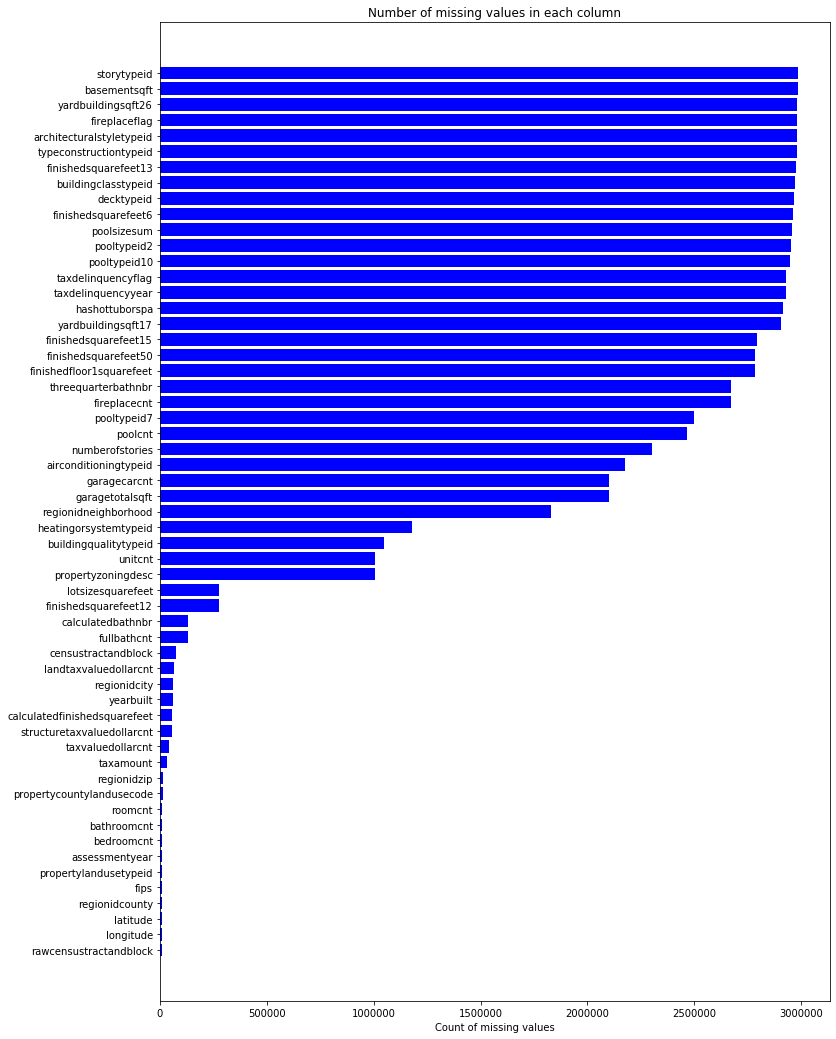

In [0]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

이제, latitude 변수와 longitude 변수를 살펴봅시다.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2272: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

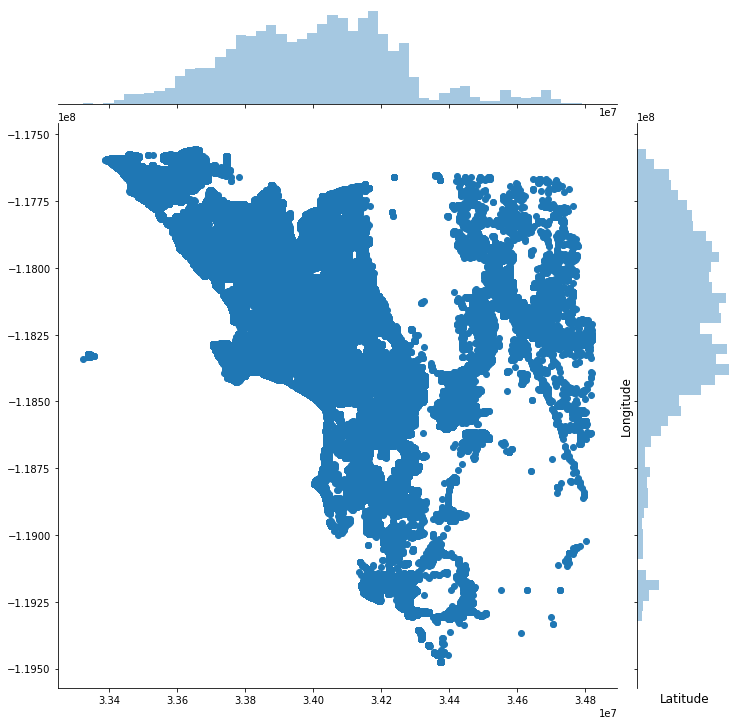

In [0]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

데이터 설명 페이지에 따르면 우리는 2016년의 3개 카운티(Los Angeles, Orange and Ventura, California)에 대한 모든 부동산 자산의 리스트를 제공받는 것이라고 명시되어 있습니다.
우리는 train 파일에서 약 90,811개의 열을 가지고 있고, properties 파일에서 약 2,985,217개의 열을 가지고 있습니다. 고로, 이 2개의 파일을 합치고, 분석을 해보도록 하겠습니다.

In [0]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


이제 변수들의 데이터 타입에 대해 확인해보죠.

In [0]:
pd.options.display.max_rows = 65
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


거의 대부분이 float 변수이고, 소량의 object (카테고리) 변수가 있습니다. 수를 세보도록 하죠.

In [0]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


이제 합쳐진 데이터셋의 Null 값의 수를 확인해보도록 하죠.

In [0]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


4개의 Column에서 결측값이 99.9%을 차지하네요.

**Univariate Analysis:**  
매우 많은 변수(variable)들이 존재하기 떄문에, 우리는 먼저 'float' 변수들만을 가지고 target 변수와 얼마나 관계되어 있는 가를 보기 위해 상관관계(correlation)를 구해보도록 하겠습니다.

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


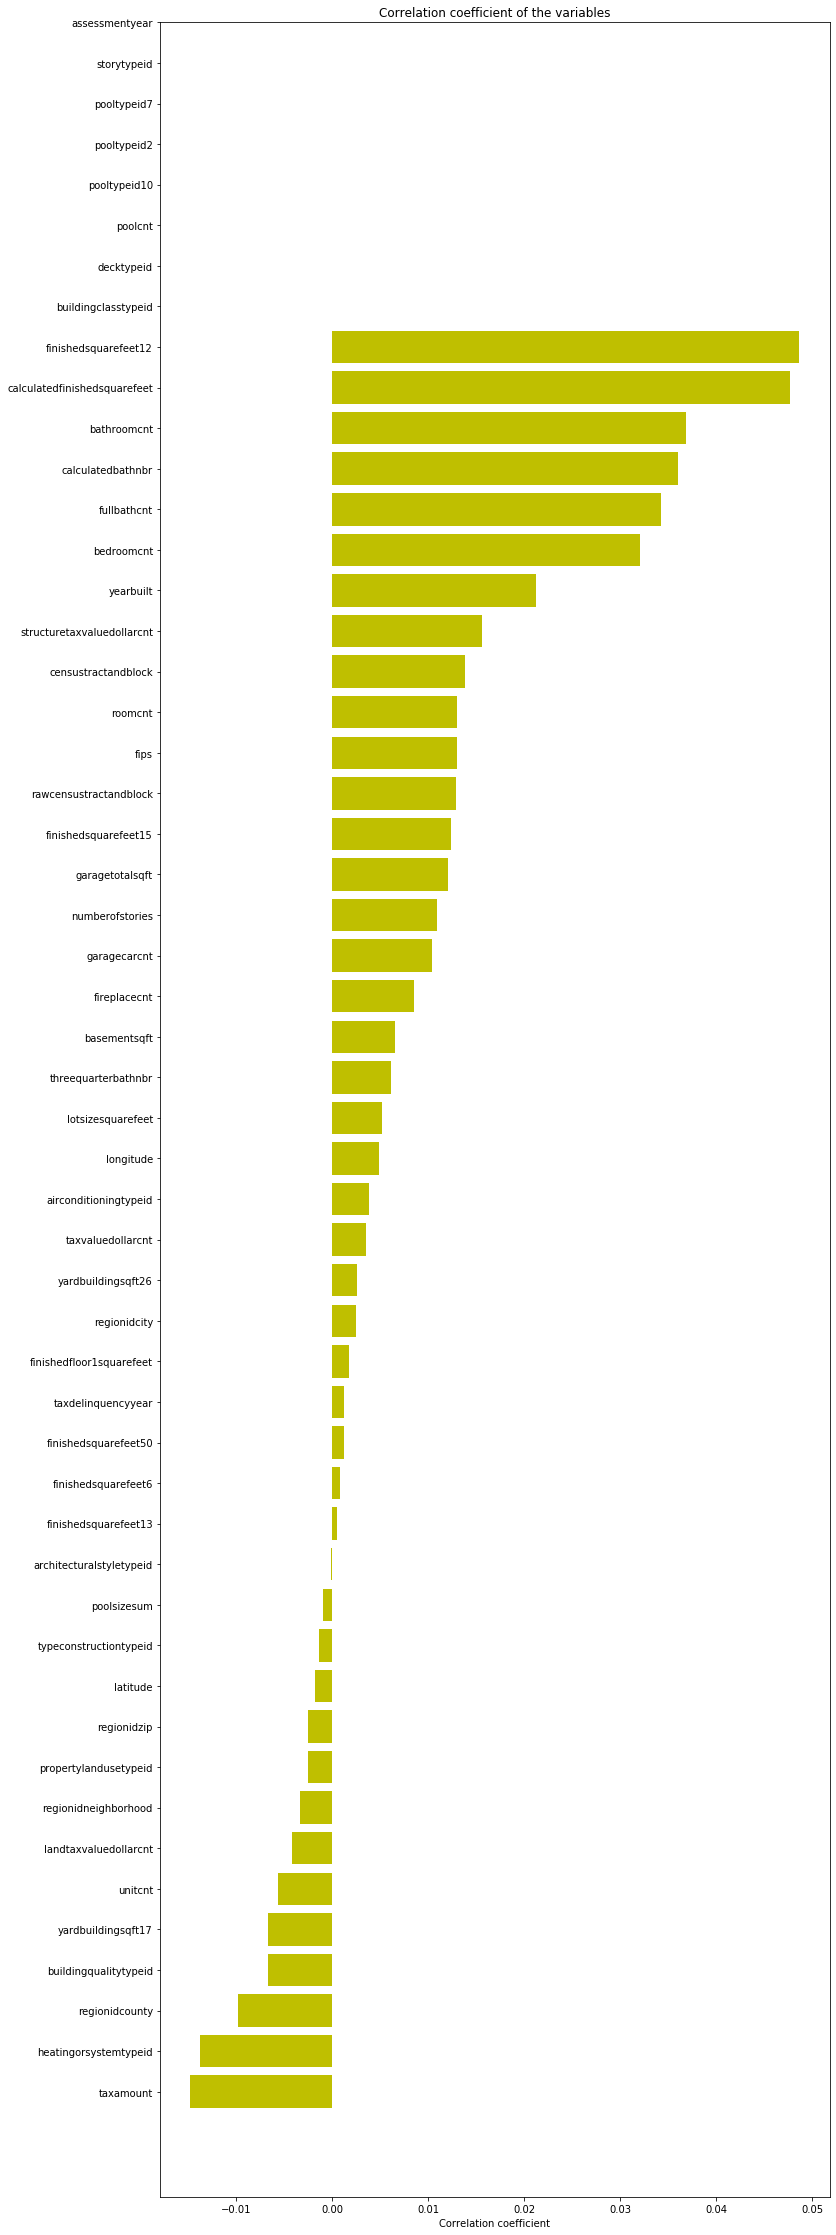

In [0]:
# 상관관계를 계산하기 위해서 먼저 결측값을 평균 값으로 채우도록 하겠습니다
mean_values = train_df.mean(axis=0)
# train_df_new = train_df.fillna(mean_values, inplace=True)
# [수정] inplace=True 속성은 None을 return하므로, 삭제하여 사용합니다.
train_df_new = train_df.fillna(mean_values)
train_df = train_df_new

# 이제 각 변수들이 상관관계를 보도록 하죠
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0, 1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

주어진 변수들과 타겟 변수와의 상관관계는 전체적으로 낮은 편이네요.  

그래프의 맨 위, 타겟 변수와 상관관계가 존재하지 않는 몇몇 변수들이 존재합니다. 제가 생각하기에 저 변수들은 오직 하나의 값으로만 이루어져있어 상관관계가 존재하지 않는 것처럼 보입니다. 제 생각이 맞나 확인해보죠. 


In [0]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


높은 상관관계 값을 가졌던 변수들을 가져와 몇가지 분석을 진행해보도록 하겠습니다.

In [0]:
corr_df_sel = corr_df[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


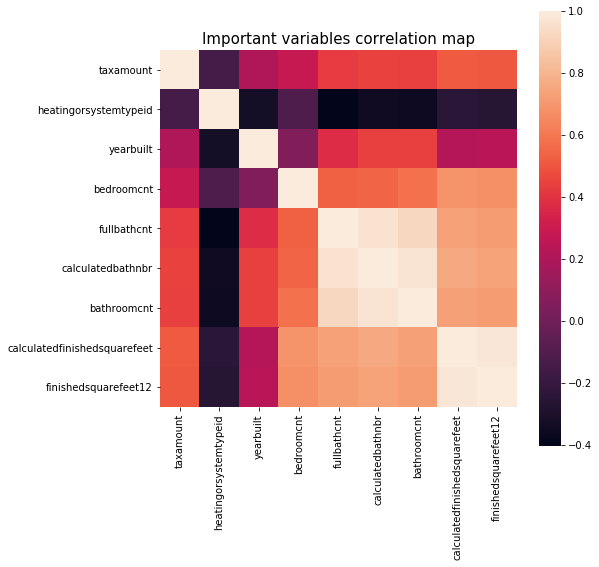

In [0]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8,8))

# seaborn을 사용한 heatmap 그리기
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

해당 변수들끼리도 매우 높은 상관관계를 갖고 있네요! 그럼, 이 변수들 각각 보도록 하죠.

**Finished SquareFeet12:**  
log error에 따라 finished square feet 12 값이 어떻게 달라지는지 보도록 하겠습니다.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2272: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

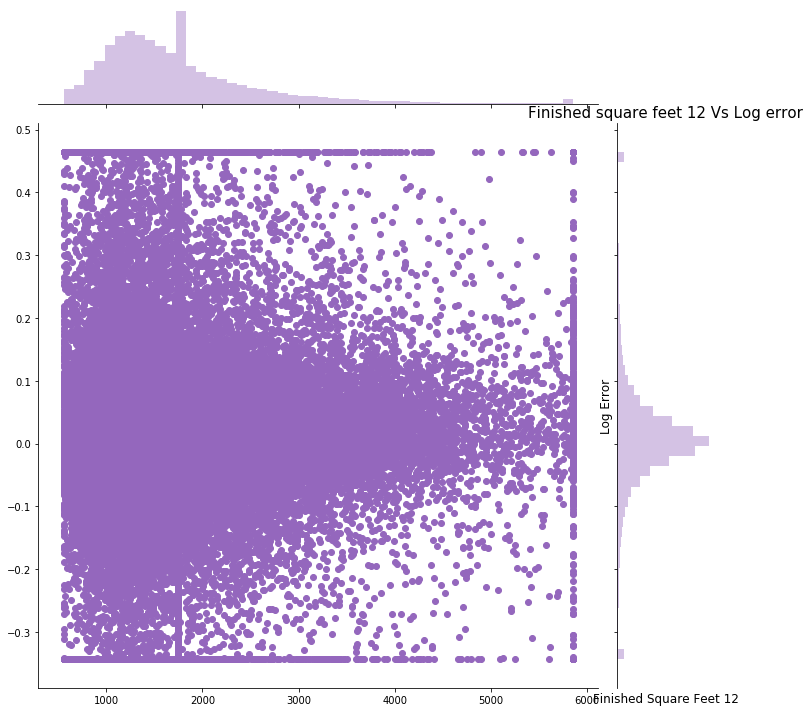

In [0]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df.loc[train_df[col]>ulimit, col] = ulimit
train_df.loc[train_df[col]<llimit, col] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

finished square feet 12 변수의 증가에 따라 logerror 범위가 좁아지는 것처럼 보입니다. 아마도 큰 집일 수록 예측하기가 쉽겠죠?

**Calculated finished square feet:**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2272: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

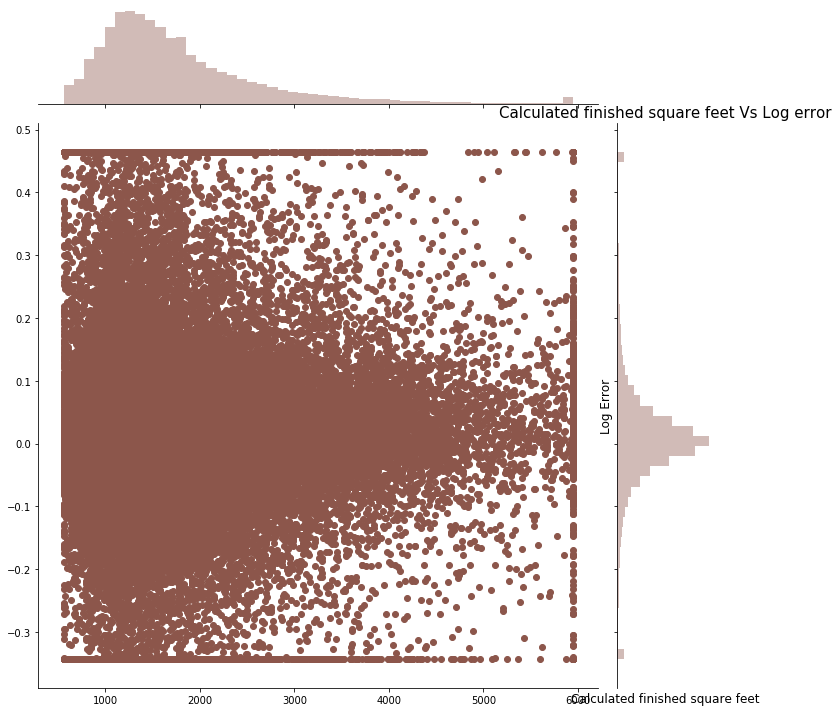

In [0]:
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

이전 변수와 분포가 비슷한 것을 알 수 있습니다. 두 변수간의 상관관계가 높았던 것이 당연한 것을 알 수 있었습니다.

**Bathroom Count:**


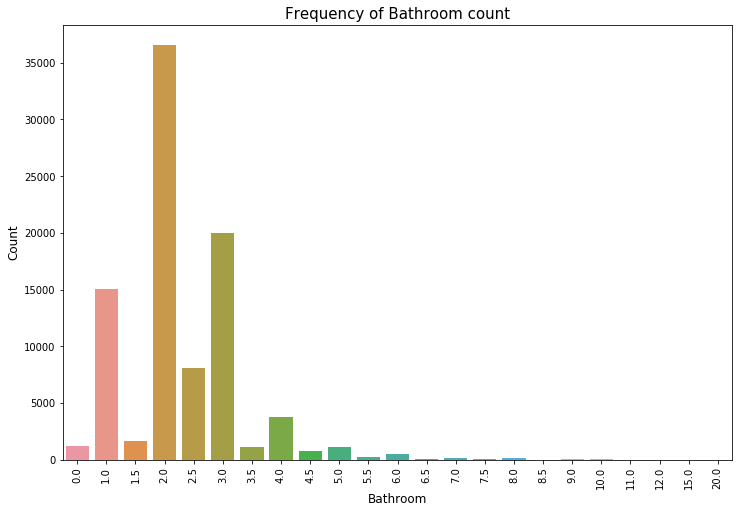

In [0]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

흥미롭게도 화장실 개수에 2.279라는 값이 존재하네요.  
EDIT : MihwaHan의 코멘트에 따르면 이건 평균 값이라고 하네요 :)   
(수정: 앞 과정에서 NaN값(결측값)을 평균으로 수정하였습니다. 고로, 2.279 같은 값이 존재할 수 있던 것 같습니다. 하지만 데이터의 업데이트에 따라 결측값이 없어짐으로써 2.279 값이 존재하지 않게 되었습니다.)
  
이제 이것에 기반해서 log error가 얼마나 변화하는지 확인해보도록 하겠습니다.

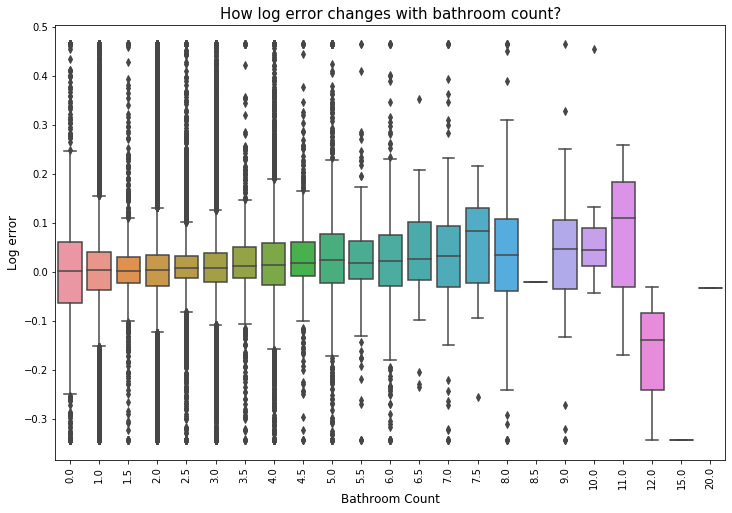

In [0]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

**Bedroom count:**

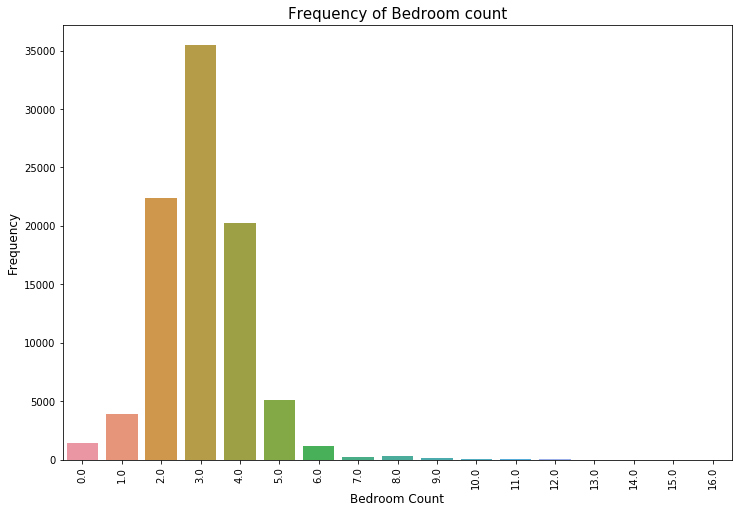

In [0]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

앞서 Null 값을 대체한 평균 값인 3.03이 존재하네요.  
(수정: 이것도 앞과 마찬가지로 데이터 업데이트에 따라 존재하지 않게 되었습니다.)


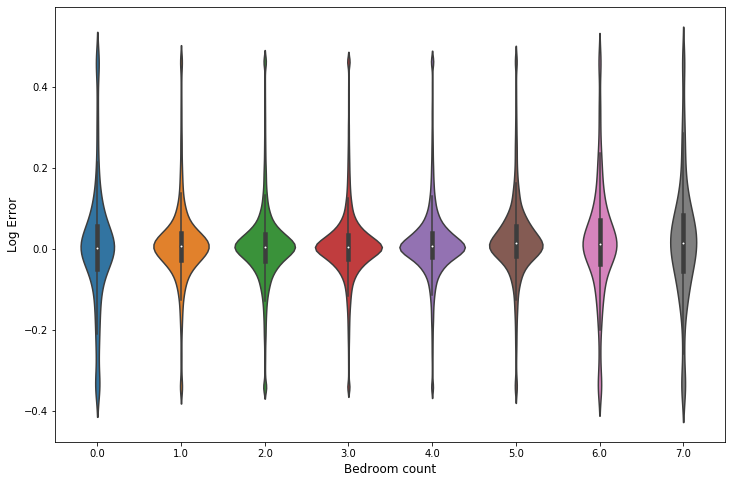

In [0]:
train_df.loc[train_df['bedroomcnt']>7, 'bedroomcnt'] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2272: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

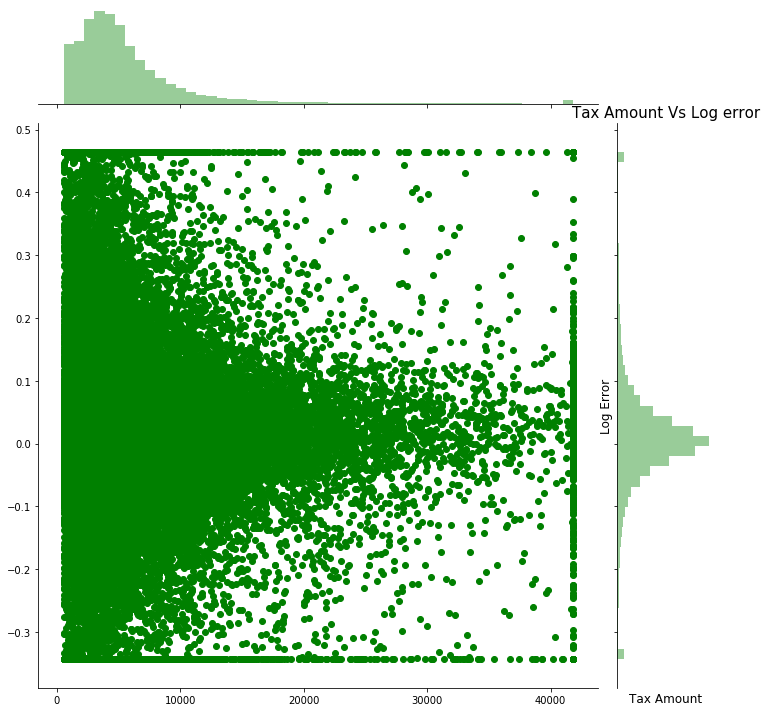

In [0]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df.loc[train_df[col]>ulimit, col] = ulimit
train_df.loc[train_df[col]<llimit, col] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

**YearBuilt:**  
yearbuilt 변수에 따라 error가 얼마나 변화하는지 살펴보도록 하겠습니다.


(수정: ggplot의 경우, pandas 최신버전을 사용하고 있지 않아 import부터 에러가 발생하고 있습니다. 업데이트가 되지 않아 직접 코드를 수정하지 않는 한 사용이 불가능할 것 같습니다. 자세한 사항은 [issue](https://github.com/yhat/ggpy/issues/662#ref-issue-467825299)와 [pull request](https://github.com/yhat/ggpy/pull/664)를 참조하세요.)

(수정: 결과 그래프는 [원본 커널](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize)을 참조 부탁드립니다.)

In [0]:
# from ggplot import *
# ggplot(aes(x='yearbuilt', y='logerror'), data=train_df) + geom_point(color='steelblue', size=1) + stat_smooth()

지어진 년도에 따라서 약간의 증가하는 추세가 있는 것처럼 보입니다.  
이제 latitude와 longitude에 따라 logerror가 얼마나 변화하는지 확인해보도록 하겠습니다.

In [0]:
#ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + geom_point() + scale_color_gradient(low = 'red', high = 'blue')

육안으로 보기에 latitude와 longitude에 따라 볼 수 있는 포켓은 존재하지 않습니다.  
높은 긍정 상관관계와 높은 부정 상관관계를 갖는 변수들에 대해 어떠한 패턴이 있는지 보도록 하겠습니다.

In [0]:
# ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + geom_point(alpha=0.7) + scale_color_gradient(low = 'pink', high = 'blue')

여기에도 시각적인 패턴이 존재하지 않는 것 같네요. 고로, 제가 생각하기에 매우 어려운 대회가 될 것 같습니다.  
재미로, 임의의 패턴을 만들어 볼까요? :D

In [0]:
# ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + geom_now_its_art()

데이터에서 멋진 패턴을 얻을 수 있었습니다. :P

Univariate 분석을 통해 우리는 중요한 변수들에 대한 이해를 할 수 있었습니다. 하지만 이는 독립적인 기준이며 또한 우리는 선형적인 가정을 가지고 있었습니다.  
이제 우리는 Extra Trees model을 사용하여 중요한 변수들을 얻기 위한 비선형 모델을 만들어보도록 하겠습니다.

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 61 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
transactiondate                 90275 non-null datetime64[ns]
transaction_month               90275 non-null int64
airconditioningtypeid           90275 non-null float64
architecturalstyletypeid        90275 non-null float64
basementsqft                    90275 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
buildingclasstypeid             90275 non-null float64
buildingqualitytypeid           90275 non-null float64
calculatedbathnbr               90275 non-null float64
decktypeid                      90275 non-null float64
finishedfloor1squarefeet        90275 non-null float64
calculatedfinishedsquarefeet    90275 non-null float64
finishedsquarefeet12            90275 non-null float64
finished

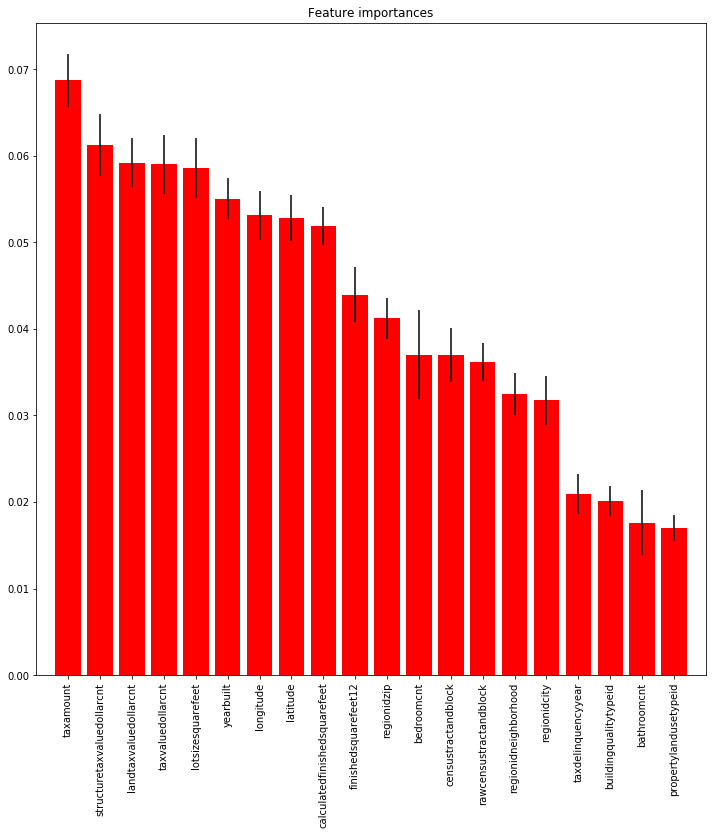

In [0]:
train_y = train_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

보기에 "tax amount"가 제일 중요한 변수로 보이고, 다음으로는 "structure tax value dollar count"와 "land tax value dollor count"가 중요한 것 같네요.

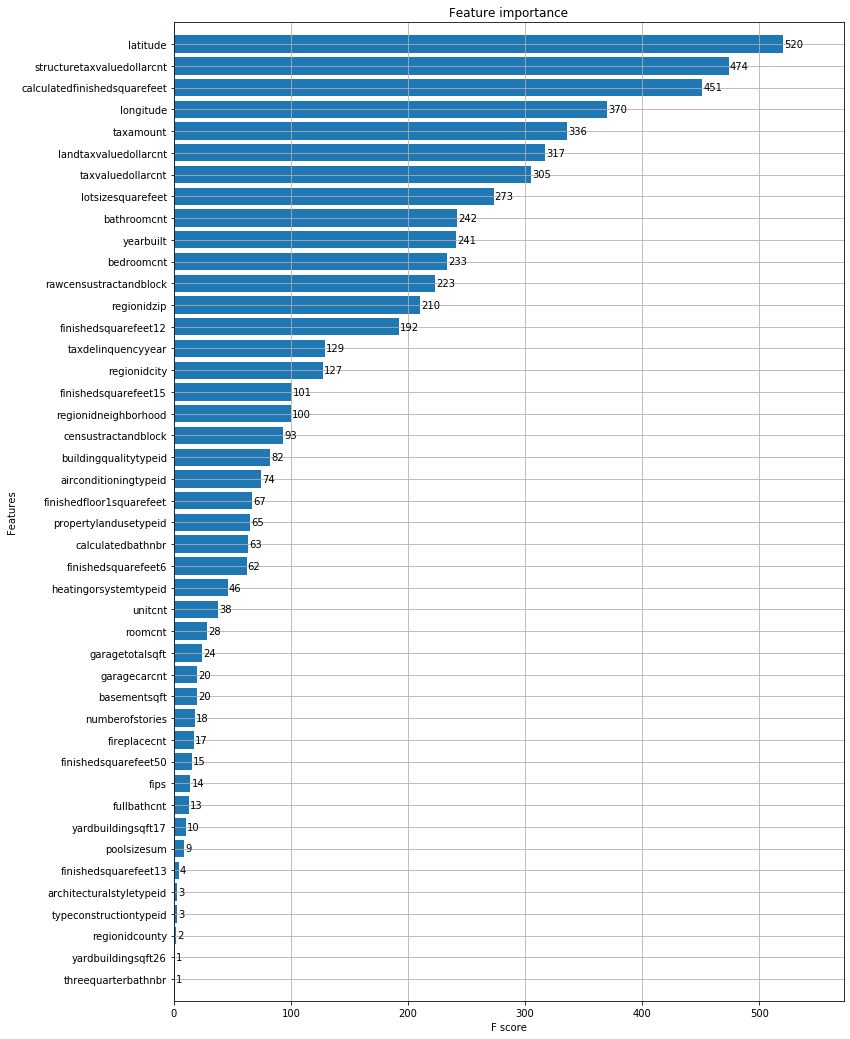

In [0]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(train_df, train_y, feature_names=train_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

xgboost를 사용하면, 중요한 변수는 'latitude',  'structured tax value dollar count', 'calculated finished square feet' 순 입니다.

**해결해야하는 것들이 많습니다. 계속 하세요 !**  
**유용했다면, upvote 부탁드려요 :)**